In [186]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import scipy
import math
import os
import sys

print(f'python version: {sys.version}')
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'nibabel version: {nib.__version__}')

NEAR_ZERO_THRESHOLD = 1e-6


def int2seg(intensity):
    if intensity <= 7:
        return f"C{intensity}"
    elif intensity > 7 and intensity <= 19:
        return f"T{intensity - 7}"
    else:
        return f"L{intensity - 19}"


df = pd.read_csv("mendez_df.csv")  #Mendez values
df.head()

python version: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:49:06) 
[Clang 14.0.6 ]
numpy version: 1.23.5
pandas version: 1.5.3
nibabel version: 5.1.0


,Segment,MEAN,STD,Mesure
0,C2,11.3,1.5,DREZ length
1,C2,12.6,0.9,Seg.L at dorsal CE
2,C2,13.1,1.0,Seg.L at BE
3,C2,24.4,0.8,Inf.Art facet to CR distance
4,C2,15.5,4.2,IF to RR distance


In [187]:
sct_dir = '../../spinalcordtoolbox/data/PAM50/template/'
print(sct_dir)

../../spinalcordtoolbox/data/PAM50/template/


In [188]:
# Import foramen data
#foramen_level = nib.load('PAM50_intervertebral_foramen_sandrine.nii.gz') # TODO add path
foramen_level = nib.load('test_foramen.nii.gz')

x_f, y_f, z_f = np.where(foramen_level.get_fdata() > NEAR_ZERO_THRESHOLD)
new_order = np.argsort(z_f)[::-1]
x_f = [x_f[i] for i in new_order]
y_f = [y_f[i] for i in new_order]
z_f = [z_f[i] for i in new_order]

In [189]:
# Import Centerline data
center = nib.load(os.path.join(sct_dir, 'PAM50_centerline.nii.gz'))
x_c, y_c, z_c = np.where(center.get_fdata() > NEAR_ZERO_THRESHOLD)
new_order = np.argsort(z_c)[::-1]
x_c = [x_c[i] for i in new_order]
y_c = [y_c[i] for i in new_order]
z_c = [z_c[i] for i in new_order]

# Import Cord data
PATH = os.path.join(sct_dir, 'PAM50_cord.nii.gz')
cord = nib.load(PATH)
p50_mask = cord.get_fdata()
x_cord, y_cord, z_cord = np.where(p50_mask > 0)
new_order = np.argsort(z_cord)[::-1]
x_cord = [x_cord[i] for i in new_order]
y_cord = [y_cord[i] for i in new_order]
z_cord = [z_cord[i] for i in new_order]

PATH_cerv = 'label_center_roots_cervical.nii.gz'
cerv = nib.load(PATH_cerv)
p50_cerv = cerv.get_fdata()
x_cerv, y_cerv, z_cerv = np.where(p50_cerv > 0)
new_order = np.argsort(z_cerv)[::-1]
x_cerv = [x_cerv[i] for i in new_order]
y_cerv = [y_cerv[i] for i in new_order]
z_cerv = [z_cerv[i] for i in new_order]


In [192]:
print(z_cerv)
print(z_f)

[960, 932, 891, 862, 830, 796, 771, 732]
[932, 898, 865, 830, 797, 765, 731, 691]
[985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958, 957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944, 943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930, 929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916, 915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902, 901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888, 887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874, 873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860, 859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846, 845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832, 831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 819, 818, 817, 816, 815, 814, 813, 812, 811, 810, 809, 808, 807, 806, 805, 804, 803, 80

## Estimate without STD
Take smallest distance bewtenn SC centerline (shifted by average diameter at dorsal rootlet entry and intervertebral foramen) (Sandrine)


In [199]:
len_level = {}
z_ref =  np.array(range(min(z_c), max(z_c) + 1))
z_c = z_ref
dist_list = {"ref": [], "caudal": [], "rostral": [], "ratio":[], "without z":[]}
level_list = []
for i in range(len(x_f)):
    # Get coordinates of intervertebral foramen
    x = x_f[i]
    y = y_f[i]
    z = z_f[i]

    # Get level
    level = int(foramen_level.get_fdata()[x, y, z])
    print('Level', level)
    print(f"IF \t x:{x} \t y:{y} \t z:{z}")
    # Get correspondance of level number (2 --> C2, etc.)
    seg = int2seg(level)
    # Get mendez measures for the corresponding level
    seg_df = df[df.Segment == seg]
    RR = seg_df[seg_df.Mesure == "IF to RR distance"]
    CR = seg_df[seg_df.Mesure == "IF to CR distance"]
    W = seg_df.loc[seg_df.Mesure == "Dorsal width"].iloc[0]
    w_mean = W.MEAN  # get mean value of dorsal width
    rr_mean = RR.MEAN.to_list()[0]  # Get mean distance from rostral rootlet to interverteral foramen
    cr_mean = CR.MEAN.to_list()[0]  # Get mean distance from caudal rootlet to interverteral foramen
    print(f"Seg: {seg} \t Rostral mean (mm): {rr_mean} \t Caudal mean(mm): {cr_mean} \t Width(mm): {w_mean}")
    w_mean = w_mean * 2
    rr_mean = rr_mean * 2
    cr_mean = cr_mean * 2
    print(f"Seg: {seg} \t Rostral mean (vx): {rr_mean} \t Caudal mean(vx): {cr_mean} \t Width(vx): {w_mean}")

    # Compute the 3D euclidean distance between intervertebral foramen and the back of the SC at dorsal width/2 lateral offset ( in mm)
    new_x = (x_c - w_mean * 0.5)[0]  # x value centerline - dorsal width /2 offset
    new_y = min(
        np.where(cord.get_fdata()[int(new_x), :, z] > 0)[0])  # y value of the SC border at x = new_x and z = foramen
    print(f"new x: {new_x}, new y: {new_y}")
    distance_foramen_ctl = np.sqrt((x_c - w_mean - x) ** 2 + (new_y - y) ** 2 + (
            z_c - z) ** 2)
    # Get the closest distance to the rostral rootlet compared to the Mendez value
    rostral_diff = np.array([np.abs(i - rr_mean) for i in distance_foramen_ctl])
    # Only use slices higher than the foramen
    rostral = np.argmin(rostral_diff[-len(z_ref[z_c > z]) - 1::])
    z_ref_r = z_c[-len(z_c[z_c > z]) - 1::]
    # Get the slice number (adjusted since the centerline starts at slice 55 not 0)
    r_z = z_ref_r[rostral]

    # Get the closest distance to the caudal rootlet compared to the Mendez value
    caudal_diff = np.array([np.abs(i - cr_mean) for i in distance_foramen_ctl])
    # Only use slices higher than the foramen
    caudal = np.argmin(caudal_diff[-len(z_ref[z_c > z]) - 1::])
    # Get the slice number (adjusted since the centerline starts at slice 55 not 0)
    c_z = z_ref_r[caudal]

    print(f"Rostral, closest dist: {rostral}, rostral slice: {r_z}")
    dist_list["rostral"].append(rr_mean)
    dist_list["caudal"].append(cr_mean)
    level_list.append(level)
    print(f"Caudal, closest dist: {caudal}, rostral slice: {c_z}")
    ref_dist = np.sqrt((x_cerv[i] - x) ** 2 + (y_cerv[i] - y) ** 2 + (
            z_cerv[i] - z) ** 2)
    #print(ref_dist)
    dist_list["ref"].append(ref_dist) # foramen to midle DREZ
    dist_list["ratio"].append(ref_dist / cr_mean)  # Ratio
    no_z = np.sqrt((x_cerv[i] - x) ** 2 + (y_cerv[i] - y) ** 2 )
    dist_list["without z"].append(no_z) # distance without z
    # Set slices
    len_level[level] = (r_z, c_z)

Level 2
IF 	 x:37 	 y:72 	 z:932
Seg: C2 	 Rostral mean (mm): 15.5 	 Caudal mean(mm): 10.6 	 Width(mm): 7.88
Seg: C2 	 Rostral mean (vx): 31.0 	 Caudal mean(vx): 21.2 	 Width(vx): 15.76
new x: 62.12, new y: 66
Rostral, closest dist: 25, rostral slice: 957
Caudal, closest dist: 11, rostral slice: 943
Level 3
IF 	 x:41 	 y:89 	 z:898
Seg: C3 	 Rostral mean (mm): 16.299999999999997 	 Caudal mean(mm): 10.8 	 Width(mm): 7.18
Seg: C3 	 Rostral mean (vx): 32.599999999999994 	 Caudal mean(vx): 21.6 	 Width(vx): 14.36
new x: 62.82, new y: 66
Rostral, closest dist: 18, rostral slice: 916
Caudal, closest dist: 0, rostral slice: 898
Level 4
IF 	 x:42 	 y:88 	 z:865
Seg: C4 	 Rostral mean (mm): 18.1 	 Caudal mean(mm): 10.1 	 Width(mm): 7.11
Seg: C4 	 Rostral mean (vx): 36.2 	 Caudal mean(vx): 20.2 	 Width(vx): 14.22
new x: 62.89, new y: 66
Rostral, closest dist: 25, rostral slice: 890
Caudal, closest dist: 0, rostral slice: 865
Level 5
IF 	 x:42 	 y:88 	 z:830
Seg: C5 	 Rostral mean (mm): 15.1 	 Ca

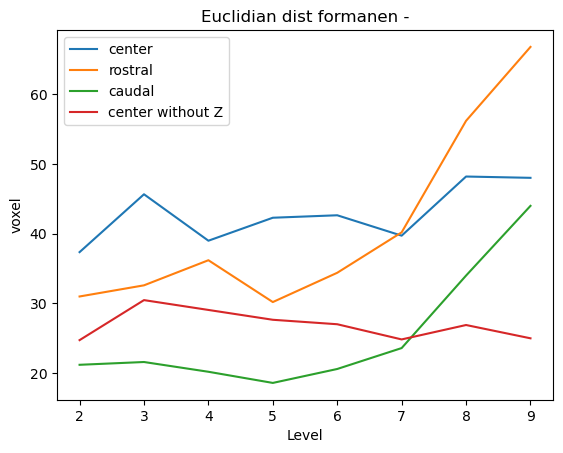

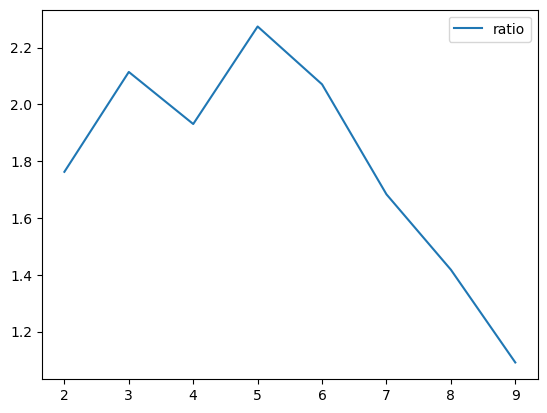

In [200]:
order = np.argsort(level_list)
#PLOT distances
plt.plot([level_list[i] for i in order], [dist_list["ref"][i] for i in order], label="center")
plt.plot([level_list[i] for i in order], [dist_list["rostral"][i] for i in order], label="rostral")
plt.plot([level_list[i] for i in order], [dist_list["caudal"][i] for i in order], label="caudal")
plt.plot([level_list[i] for i in order], [dist_list["without z"][i] for i in order], label="center without Z")
plt.title("Euclidian dist formanen -")
plt.xlabel("Level")
plt.ylabel("voxel")
plt.legend()
plt.show()

#plot ratio
plt.plot([level_list[i] for i in order], [dist_list["ratio"][i] for i in order], label="ratio")
plt.legend()

plt.show()


In [201]:
cord_mask = np.copy(p50_mask)
for lvl in len_level:
    level_r = int(len_level[lvl][0])
    level_c = int(len_level[lvl][1])
    cord_mask[:, :, level_r][cord_mask[:, :, level_r] > 0] = lvl
    cord_mask[:, :, level_c][cord_mask[:, :, level_c] > 0] = lvl
cord_mask[:, :, :][cord_mask[:, :, :] == 1] = 0
test_img = nib.Nifti1Image(cord_mask, header=cord.header, affine=cord.affine)
nib.save(test_img, f'foramen_label_without_std.nii.gz')  # TO CHANGE path output

## Estimate with STD 
Take smallest distance bewtenn SC centerline (shifted by average diameter at dorsal rootlet entry and intervertebral foramen) (Sandrine)


In [ ]:
z_ref = np.array(range(min(z_c), max(z_c) + 1))
z_c = z_ref
for i in range(len(x_f)):
    # Get coordinates of intervertebral foramen
    x = x_f[i]
    y = y_f[i]
    z = z_f[i]
    # Get level
    level = int(foramen_level.get_fdata()[x, y, z])
    print('Level', level)
    # Get correspondance of level number (2 --> C2, etc.)
    seg = int2seg(level)
    print(seg)
    # Get mendez measures for the corresponding level
    seg_df = df[df.Segment == seg]
    RR = seg_df[seg_df.Mesure == "IF to RR distance"]
    CR = seg_df[seg_df.Mesure == "IF to CR distance"]
    W = seg_df.loc[seg_df.Mesure == "Dorsal width"].iloc[0]
    w_mean = W.MEAN  # get mean value of dorsal width
    rr_mean = RR.MEAN.to_list()[0]  # Get mean distance from rostral rootlet to interverteral foramen
    cr_mean = CR.MEAN.to_list()[0]  # Get mean distance from caudal rootlet to interverteral foramen
    rr_std = RR.STD.to_list()[0]  # Get std for mean distance from rostral rootlet to interverteral foramen
    cr_std = CR.STD.to_list()[0]  # Get std for mean distance from caudal rootlet to interverteral foramen
    # Get distance for +/- 95% probability
    min_rr = rr_mean - 2 * rr_std
    max_rr = rr_mean + 2 * rr_std
    min_cr = cr_mean - 2 * cr_std
    max_cr = cr_mean + 2 * cr_std
    print("Rostral dist", max_rr, rr_mean, min_rr)
    print("Caudal dist", max_cr, cr_mean, min_cr)
    # Compute the 3D euclidean distance between intervertebral foramen and the back of the SC at dorsal width/2 lateral offset ( in mm)
    new_x = (x_c - w_mean)[0]  # x value centerline - dorsal width /2 offset
    new_z = min(
        np.where(cord.get_fdata()[int(new_x), :, z] > 0)[0])  # y value of the SC border at x = new_x and z = foramen
    distance_foramen_ctl = np.sqrt((x_c - w_mean - x) ** 2 + (new_z - y) ** 2 + (
            z_c - z) ** 2) * 0.5  # 0.5 --> pix dim of PAM50 TODO: remove hardcode
    # min std : most caudal point of the probabilistic distribution 
    # max std : most rostral point of the probabilistic distribution 
    # List with estimation of z value for rostral and caudal (min std, max std, mean)
    all_level = []
    for distance in [max_rr, min_rr, rr_mean, max_cr, min_cr, cr_mean]:
        # Get the closest distance to the rostral rootlet compared to the Mendez value
        rostral_diff = np.array([np.abs(i - distance) for i in distance_foramen_ctl])
        # Only use slices higher than the foramen
        estimate = np.argmin(rostral_diff[-len(z_c[z_c > z]) - 1::])
        z_ref_i = z_ref[-len(z_c[z_c > z]) - 1::]
        # Get the slice number (adjusted since the centerline starts at slice 55 not 0)
        value = z_ref_i[estimate]
        all_level.append(int(value))

    print('Rostral', rr_mean, distance_foramen_ctl[-len(z_c[z_c > z]) - 1::][rostral], all_level[2], z)
    print('Caudal', cr_mean, distance_foramen_ctl[-len(z_c[z_c > z]) - 1::][caudal], all_level[5], z)
    # Set colored label from 0 (the least probable) to 20 (mean value)
    cord_mask = np.copy(p50_mask)
    # Max to mean rostral
    for rng in range(all_level[2], all_level[0]):
        if abs(all_level[0] - all_level[2]) != 0:
            proba = 19 * abs(rng - all_level[2]) / (abs(all_level[0] - all_level[2])) + 1
            cord_mask[:, :, rng][cord_mask[:, :, rng] > 0] = 20 - proba
    # Mean to min rostral 
    for rng in range(all_level[1], all_level[2]):
        if abs(all_level[2] - all_level[1]) != 0:
            proba = 19 * abs(rng - all_level[1]) / (abs(all_level[2] - all_level[1])) + 1
            cord_mask[:, :, rng][cord_mask[:, :, rng] > 0] = proba
    # Max to mean caudal
    for rng in range(all_level[5], all_level[3]):
        if abs(all_level[3] - all_level[5]) != 0:
            proba = 19 * abs(rng - all_level[5]) / (abs(all_level[3] - all_level[5])) + 1
            cord_mask[:, :, rng][cord_mask[:, :, rng] > 0] = 20 - proba
    # Mean to min caudal
    for rng in range(all_level[4], all_level[5]):
        if abs(all_level[5] - all_level[4]) != 0:
            proba = 19 * abs(rng - all_level[4]) / (abs(all_level[5] - all_level[4])) + 1
            cord_mask[:, :, rng][cord_mask[:, :, rng] > 0] = proba
    # Mean value caudal and rostral = 20
    for l in (all_level[2], all_level[5]):
        cord_mask[:, :, l][cord_mask[:, :, l] > 0] = 20
    cord_mask[:, :, :][cord_mask[:, :, :] == 1] = 0
    test_img = nib.Nifti1Image(cord_mask, header=cord.header, affine=cord.affine)
    nib.save(test_img, f'Outputs/spinal_level_std_{level}.nii.gz')  # TO CHANGE path output